# Week 13, End to End model. 

This notebook will cover each major step in the model development life cycle, from pulling in data, cleaning it and getting it ready for the model, to building the model and packaging it. 

In [1]:
from _Setup import *
from _Functions import *

Installing dependencies from requirements.txt...
All dependencies installed successfully.
Project root directory is: C:\AA-Capstone\End2End_Project


# Import Data and Cleaning.

This section imports the data, applies some data cleaning functions for some data inconsistencies that we noted in the current dataset. We also note here that "2025 (FYTD)" only applies to the current fiscal year, so if this pipeline is utilized further in the future, this line will need to be changed. In addition, it will now calculate the cutoff date for the train/test split. 

In [2]:
# Import sector-level data
sector_df = pd.read_csv(sector_data_csv_path, low_memory=False)

sector_df.replace(to_replace="2025 (FYTD)", value=2025, inplace=True)
sector_df.replace(to_replace='2024', value=2024, inplace=True)

# Apply the function to create a Year-Date column in fytd_df
sector_df['Year-Date'] = sector_df.apply(lambda row: convert_to_fiscal_year_date(row), axis=1)

# Convert the new column to datetime format
sector_df['Year-Date'] = pd.to_datetime(sector_df['Year-Date'], format='%Y-%m-%d')

# Dynamically calculate the cutoff date for the last six months
last_six_months = sector_df['Year-Date'].sort_values().unique()[-6:]  # Get the last 6 unique months
cutoff_date = last_six_months[0]  # The earliest date in the last six months

print(f"Cutoff date is :{cutoff_date}")


Cutoff date is :2024-07-01 00:00:00


In [ ]:
# Split the data into training and testing sets dynamically
train_df = sector_df[sector_df['Year-Date'] < cutoff_date]
test_df = sector_df[sector_df['Year-Date'] >= cutoff_date]

# Save the dataframes to csv
train_df.to_csv(sector_data_csv_path_train, index=False)
test_df.to_csv(sector_data_csv_path_test, index=False)

# These columns should be captured in Year-Date and we remove abbreviated columns that are unnecessary.
columns_to_remove = ["Fiscal Year", "Month Grouping", "Month (abbv)", "AOR (Abbv)"]
sector_train_dropped = train_df.drop(columns = columns_to_remove)
sector_test_dropped = test_df.drop(columns = columns_to_remove)

This section creates the datasets that we use for our train and test sets.

In [3]:

# Aggregating by 'Area of Responsibility' and 'Year-Date'
sector_train_aggregated = sector_train_dropped.groupby(["Area of Responsibility", "Year-Date"], as_index=False).agg({"Encounter Count": "sum"})
sector_train_pivot = sector_train_aggregated.pivot(index = "Area of Responsibility", columns = "Year-Date", values="Encounter Count")
sector_train_pivot = sector_train_pivot.fillna(0)
sector_train_pivot.to_csv(sector_data_csv_path_train_pivoted)

# Aggregating by 'Area of Responsibility' and 'Year-Date'
sector_test_aggregated = sector_test_dropped.groupby(["Area of Responsibility", "Year-Date"], as_index=False).agg({"Encounter Count": "sum"})
sector_test_pivot = sector_test_aggregated.pivot(index = "Area of Responsibility", columns = "Year-Date", values="Encounter Count")
sector_test_pivot = sector_test_pivot.fillna(0)
sector_test_pivot.to_csv(sector_data_csv_path_test_pivoted)

Once we apply scalers on each sector, we save these scalers into a pickle file for use later to un-scale the predicted values. 

In [4]:
# Dictionary to store scalers
scalers = {}

# Iterate through rows and fit a separate MinMaxScaler for each row
for idx, row in sector_train_pivot.iterrows():
    scaler = MinMaxScaler()
    
    # Reshape row into a 2D array with a single column to fit the scaler
    row_array = row.to_numpy().reshape(-1, 1)  
    tf = scaler.fit_transform(row_array)  # Fit scaler to the row
    
    # Store the scaler using the row index as the key
    scalers[idx] = scaler

# Save the list to a .pickle file
with open(scalers_file, "wb") as file:
    pickle.dump(scalers, file)

Although we already have that dataframe active in the notebook, this code would essentially allow someone to skip all of the data importing and cleaning process, just run the first block and jump down here.
It also shortens the name of the dataframe..

In [5]:
sector_train = pd.read_csv(sector_data_csv_path_train_pivoted, index_col='Area of Responsibility')

# Create an empty DataFrame to store scaled values
sector_train_scaled = pd.DataFrame(index=sector_train.index, columns=sector_train.columns)

# Apply each pre-trained scaler row-wise
for index, row in sector_train.iterrows():
	scaler = scalers[index]
	scaled_row = scaler.transform(row.values.reshape(-1, 1)).flatten()
	sector_train_scaled.loc[index] = scaled_row


test_data = pd.read_csv(sector_data_csv_path_test_pivoted, index_col='Area of Responsibility')	

In [6]:
sector_train

,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,...,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01
Area of Responsibility,,,,,,,,,,,,,,,,,,,,,
Atlanta Field Office,1022.0,762.0,564.0,527.0,521.0,847.0,1037.0,2141.0,1532.0,1428.0,...,1150.0,917.0,1172.0,987.0,1073.0,954.0,1054.0,1047.0,1073.0,1009.0
Baltimore Field Office,443.0,550.0,658.0,698.0,660.0,367.0,85.0,177.0,150.0,116.0,...,1748.0,1591.0,1521.0,1539.0,1565.0,1586.0,1440.0,1290.0,1253.0,1408.0
Big Bend Sector,653.0,526.0,543.0,604.0,562.0,675.0,507.0,628.0,660.0,746.0,...,560.0,479.0,426.0,322.0,324.0,568.0,436.0,529.0,751.0,215.0
Blaine Sector,32.0,24.0,36.0,25.0,27.0,16.0,6.0,13.0,5.0,15.0,...,218.0,229.0,198.0,291.0,223.0,235.0,226.0,330.0,266.0,181.0
Boston Field Office,1395.0,1001.0,1558.0,950.0,1350.0,611.0,292.0,54.0,279.0,208.0,...,5576.0,3446.0,3250.0,4236.0,4508.0,3611.0,4736.0,4945.0,4809.0,4514.0
Buffalo Field Office,1088.0,1065.0,1163.0,1343.0,3946.0,2286.0,112.0,178.0,359.0,403.0,...,6335.0,5274.0,4926.0,5131.0,4984.0,4547.0,4834.0,4460.0,5259.0,4933.0
Buffalo Sector,25.0,11.0,11.0,47.0,13.0,10.0,3.0,6.0,39.0,42.0,...,10.0,32.0,31.0,31.0,38.0,43.0,32.0,13.0,60.0,36.0
Chicago Field Office,349.0,294.0,329.0,307.0,325.0,237.0,115.0,188.0,152.0,329.0,...,2078.0,1883.0,1505.0,1606.0,1121.0,1396.0,1462.0,1751.0,2198.0,2147.0
Del Rio Sector,3198.0,3119.0,3003.0,2348.0,2622.0,2619.0,2027.0,2289.0,3471.0,4163.0,...,45688.0,38206.0,42930.0,71048.0,16710.0,14102.0,11270.0,10271.0,10095.0,7640.0


# Model Training and Fine Tuning ARIMA parameters

This section produces ARIMA models for each Sector/Field office in the training set. It stores the best models as well as its predictions for use in calculating the overall MAPE of all modelled sectors.

In [7]:
warnings.filterwarnings("ignore")  # Suppress warnings

# Define the range of ARIMA parameters to search
p_values = range(0, 4)  # Autoregressive terms
d_values = range(0, 2)  # Differencing order
q_values = range(0, 4)  # Moving average terms

# Generate all (p, d, q) combinations safely
pdq_combinations = list(itertools.product(p_values, d_values, q_values))

model_dict = {}

mapes = []

# Ensure all values are valid integers (avoid NaNs, None, etc.)
fixed_pdq_combinations = [
    tuple(int(value) for value in order)  # Explicit integer conversion
    for order in pdq_combinations
]

# Dictionary to store predictions
predictions_dict = {}

# Iterate over each time series row
for index, row in sector_train_scaled.iterrows():
    try:
        # Convert row to numeric and drop NaN values
        input_series = pd.to_numeric(row, errors='coerce').dropna().values.flatten()

        # Ensure input_series is numeric and of sufficient length
        if len(input_series) < 3:
            print(f"Skipping index {index}: Not enough data points for ARIMA.")
            continue
        
        # Grid search to find the best ARIMA parameters
        best_aic = float("inf")
        best_order = None
        best_model = None
        best_residuals = None

        for order in fixed_pdq_combinations:
            try:
                model = ARIMA(input_series, order=order)
                fitted_model = model.fit()
                aic = fitted_model.aic  # Akaike Information Criterion

                if aic < best_aic:
                    best_aic = aic
                    best_order = order
                    best_model = fitted_model
                    best_residuals = np.array(fitted_model.resid)

                    model_dict[index] = best_model

            except Exception as e:
                print(f"Skipping ARIMA{order} for index {index}: {e}")
                continue  # Skip parameter sets that fail to converge

        # Ensure a valid model was selected
        if best_model is not None and index in test_data.index:
            test_set = test_data.loc[index]
            steps_ahead = len(test_set)

            if steps_ahead > 0:
                try:
                    # Forecast future values
                    predictions = best_model.forecast(steps=steps_ahead).flatten()

                    # Inverse transform predictions if applicable
                    if index in scalers:
                        predictions = scalers[index].inverse_transform(
                            predictions.reshape(-1, 1)
                        ).flatten()

                    # Store predictions
                    predictions_dict[index] = predictions

                except Exception as e:
                    print(f"Error in forecasting for {index}: {e}")
                    

    except Exception as e:
        print(f"Skipping index {index} due to unexpected error: {e}")

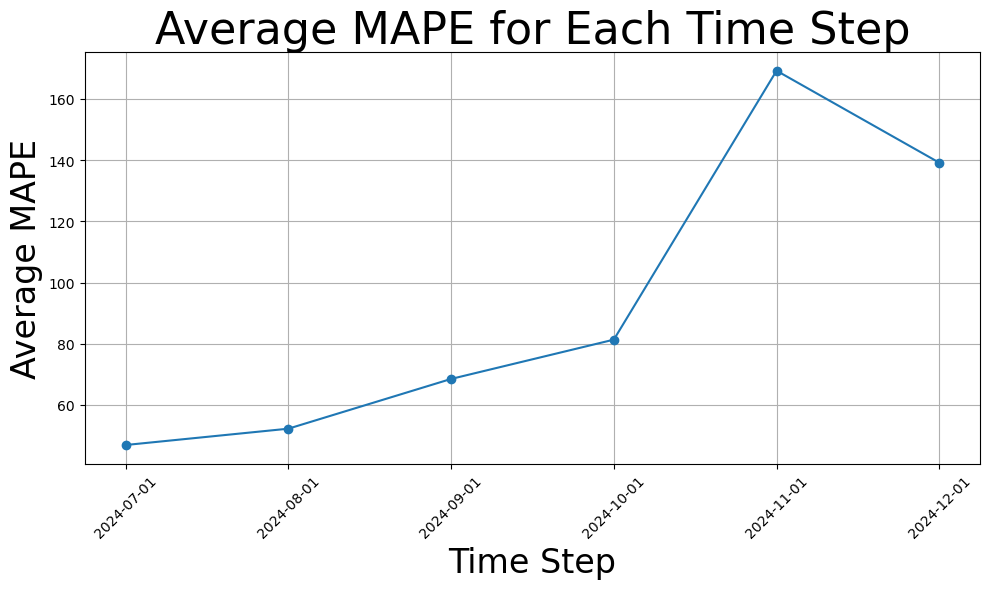

In [8]:
# Initialize a dictionary to store MAPE values for each time step
mape_dict = {col: [] for col in test_data.columns}

# Iterate over each index in the predictions dictionary
for index, predictions in predictions_dict.items():
    if index in test_data.index:
        actuals = test_data.loc[index].values
        for i, col in enumerate(test_data.columns):
            if i < len(predictions):
                mape = calculate_mape(predictions[i], actuals[i])
                mape_dict[col].append(mape)

# Calculate the average MAPE for each time step
average_mape_dict = {col: np.mean(mapes) for col, mapes in mape_dict.items()}


# Plot the average MAPE for each time step
plt.figure(figsize=(10, 6))
plt.plot(list(average_mape_dict.keys()), list(average_mape_dict.values()), marker='o')
plt.title('Average MAPE for Each Time Step', fontsize=32)
plt.xlabel('Time Step', fontsize=24)
plt.ylabel('Average MAPE', fontsize=24)
plt.grid(True)
plt.xticks(rotation=45)

mape_result_file = os.path.join(final_output_folder, "average_mape.png")
plt.savefig(mape_result_file)
plt.tight_layout()
plt.show()


# Monitoring Model Performance

This section creates the visualizations for each individual sector and its predicted vs actual encounter counts. There are two versions, one has the complete dataset while the other is zoomed into the most recent 24 time steps (24 months/2 years). This allows for a better view of the predictions. The goal of these visualizations is to provide the user with feedback on the model performance. 

In [13]:
for sector_name in sector_train_scaled.index:
    if (
        sector_name in test_data.index 
        and sector_name in predictions_dict
    ):
        # Inverse transform train data
        train_series = sector_train_scaled.loc[sector_name]
        train_data = scalers[sector_name].inverse_transform(train_series.values.reshape(-1, 1)).flatten()
        
        # Extract test and predicted data
        test_series = test_data.loc[sector_name].astype(float)
        predicted_data = predictions_dict[sector_name]
    
        # Create time indices
        train_index = train_series.index if hasattr(train_series, "index") else range(len(train_data))
        test_index = test_series.index
    
        # Concatenate time steps for tick control
        full_index = list(train_index) + list(test_index)
    
        # Plot full visualization
        plt.figure(figsize=(12, 6))
        plt.plot(train_index, train_data, label="Train Data", marker='o')
        plt.plot(test_index, test_series.values, label="Test Data", marker='o')
        plt.plot(test_index[:len(predicted_data)], predicted_data, label="Predicted Data", marker='o')
    
        plt.title(f"Train, Test, and Predicted Data for {sector_name}", fontsize=24)
        plt.xlabel("Time Step", fontsize=16)
        plt.ylabel("Values", fontsize=16)
        plt.legend()
        plt.grid(True)
    
        # Set x-ticks to every 6th step
        xticks = full_index[::6]
        plt.xticks(ticks=xticks, rotation=45)
    
        plt.tight_layout()
        full_plot_path = os.path.join(full_visualizations_folder, f"{sector_name.replace(' ', '_')}_full.png")
        plt.savefig(full_plot_path)
        plt.close()
    
        # Plot zoomed-in visualization (recent years)
        plt.figure(figsize=(12, 6))
        zoomed_train_index = train_index[-24:]  # Adjust range for recent years
        zoomed_train_data = train_data[-24:]
        zoomed_test_index = test_index[:24]  # Adjust range for recent years
        zoomed_test_data = test_series.values[:24]
        zoomed_predicted_data = predicted_data[:24]
    
        plt.plot(zoomed_train_index, zoomed_train_data, label="Train Data (Recent)", marker='o')
        plt.plot(zoomed_test_index, zoomed_test_data, label="Test Data (Recent)", marker='o')
        plt.plot(zoomed_test_index[:len(zoomed_predicted_data)], zoomed_predicted_data, label="Predicted Data (Recent)", marker='o')
    
        plt.title(f"Zoomed-In Train, Test, and Predicted Data for {sector_name}", fontsize=24)
        plt.xlabel("Time Step", fontsize=16)
        plt.ylabel("Values", fontsize=16)
        plt.legend()
        plt.grid(True)


        # Set x-ticks to every 4th step for zoomed-in visualization
        zoomed_xticks = list(zoomed_train_index[::4]) + list(zoomed_test_index[::4])
        plt.xticks(ticks=zoomed_xticks, rotation=45)
        plt.tight_layout()
        
        zoomed_plot_path = os.path.join(zoomed_visualizations_folder, f"{sector_name.replace(' ', '_')}_zoomed.png")
        plt.savefig(zoomed_plot_path)
        plt.close()
    
    else:
        print(f"Data for {sector_name} is not available in train, test, or predictions.")

# Model Saving

Here we grab the models that we trained and saved earlier, before we drop them into .pkl files for compression, storage, and deployment purposes. 

In [10]:
for k, v in model_dict.items():
    file_name = k.replace(" ", "_") + '_arima_model.pkl'
    file_path = os.path.join(saved_models_folder, file_name)
    # Save model to pickle file
    with open(file_path, 'wb') as f:
        pickle.dump(v, f)

This code here allows you to reload those models from the pickle format. 

In [14]:
# Initialize an empty dictionary to store the models
loaded_models = {}

# Iterate through the saved pickle files in the folder
for file_name in os.listdir(saved_models_folder):
    if file_name.endswith('_arima_model.pkl'):
        # Extract the key (sector name) from the file name
        sector_name = file_name.replace('_arima_model.pkl', '').replace('_', ' ')
        
        # Load the model from the pickle file
        file_path = os.path.join(saved_models_folder, file_name)
        with open(file_path, 'rb') as f:
            loaded_models[sector_name] = pickle.load(f)